# 🧨 Fast Stable Diffusion in free Colab with JAX / Flax on TPU!

🤗 Hugging Face [Diffusers](https://github.com/huggingface/diffusers) supports Flax since version `0.5.0`! This allows for snappy inference on Google TPUs, such as those available in Colab, Kaggle or through Google Cloud Platform.

If you want more details about how Stable Diffusion works using JAX please refer to [our blog](#) or [this Colab notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb).

## Setup

In [ ]:
#@title Set up JAX
#@markdown If you see an error, make sure you are using a TPU backend. Select `Runtime` in the menu above, then select the option "Change runtime type" and then select `TPU` under the `Hardware accelerator` setting.
!pip install --upgrade jax jaxlib 
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu('tpu_driver_20221011')

import jax
jax.devices()



In [ ]:
#@title Install required libraries
!pip install git+https://github.com/huggingface/diffusers.git transformers huggingface_hub==0.10.0 flax ftfy

In [ ]:
#@title Login to the Hugging Face Hub
#@markdown Make sure you also have read and accept the LICENSE of the [Stable Diffusion model](https://huggingface.co/CompVis/stable-diffusion-v1-4), otherwise you may find an error
from huggingface_hub import notebook_login
!git config --global credential.helper store

notebook_login()

In [ ]:
#@title Import required libraries
import numpy as np
import jax
import jax.numpy as jnp

from pathlib import Path
from jax import pmap
from flax.jax_utils import replicate
from flax.training.common_utils import shard
from PIL import Image

from huggingface_hub import notebook_login
from diffusers import FlaxStableDiffusionPipeline
import torch
def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [ ]:
#@title Load the model
#@markdown It's safe to ignore the warning messages, everything is okay
pipeline, params = FlaxStableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="bf16", dtype=jnp.bfloat16)
p_params = replicate(params)
prng_seed = jax.random.PRNGKey(1)
prng_seed = jax.random.split(prng_seed, jax.device_count())

## Run!

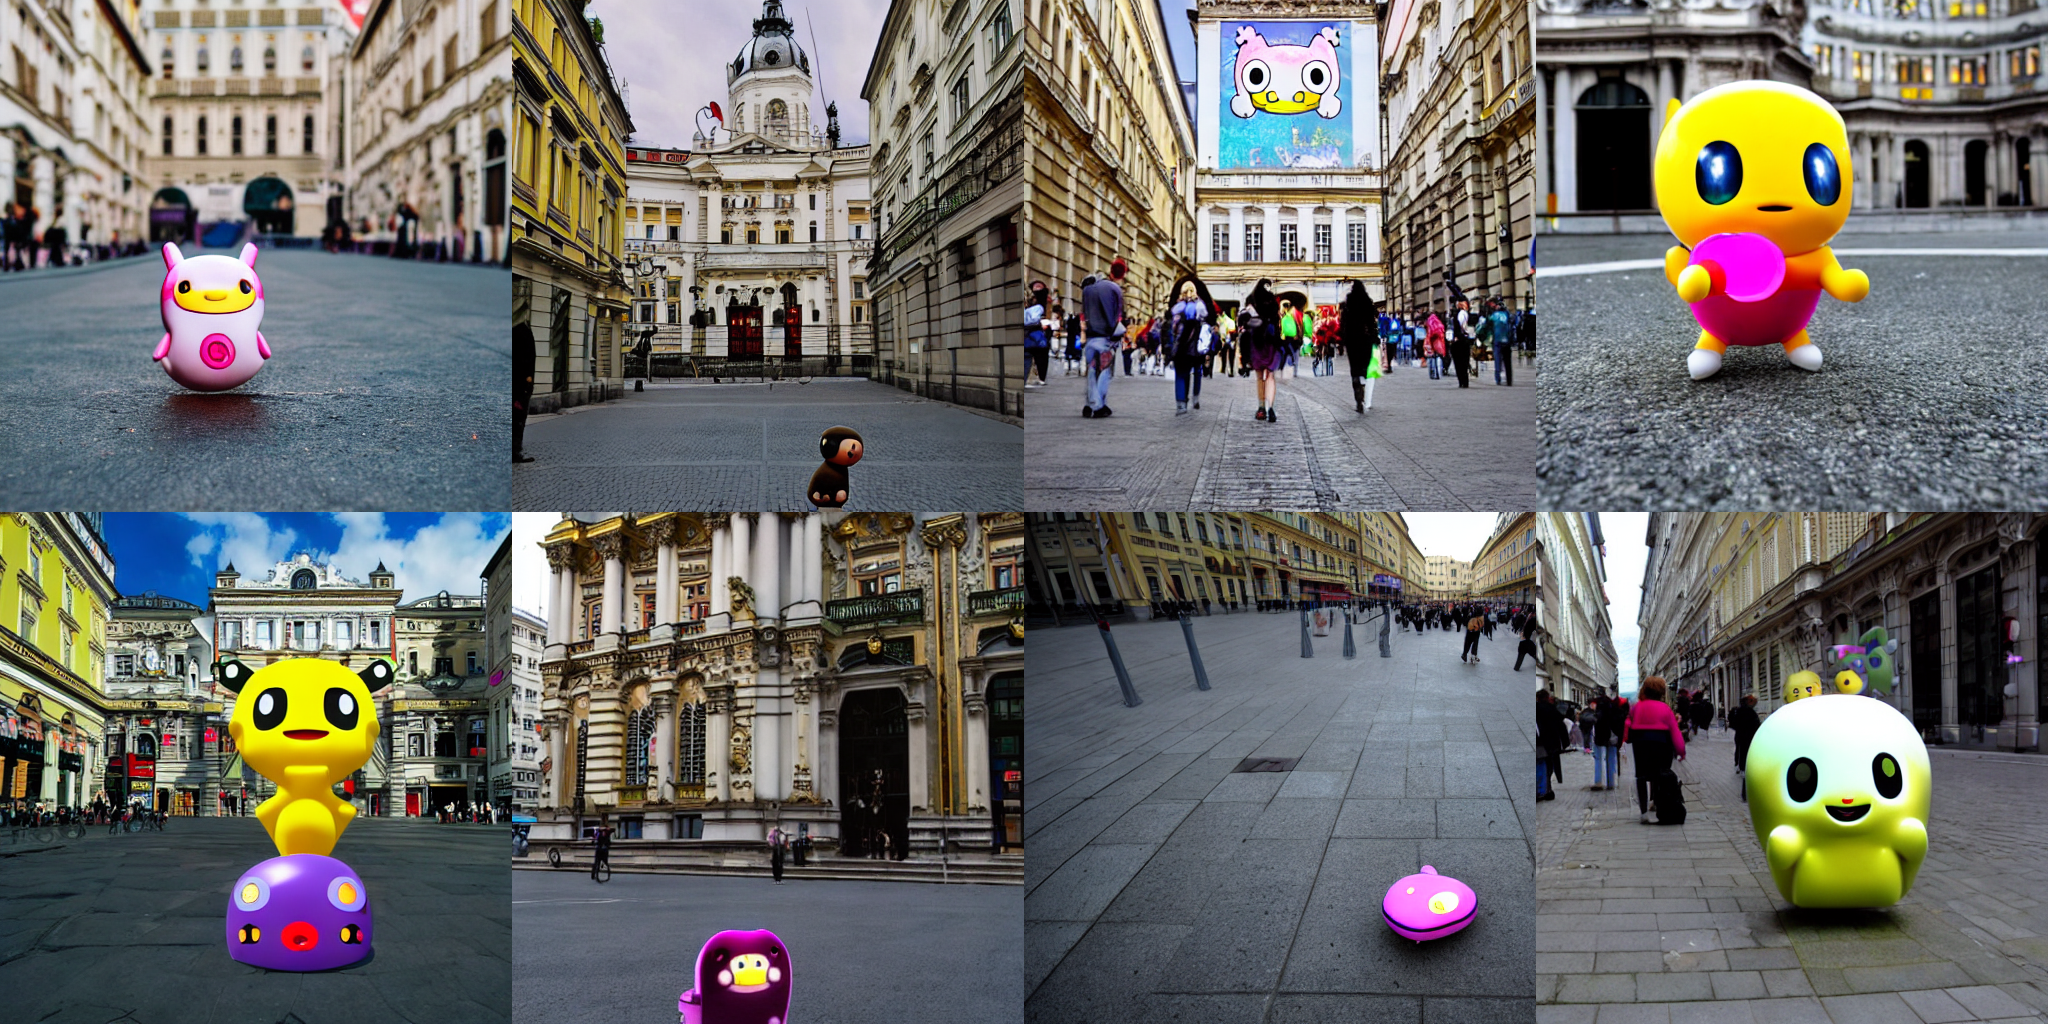

In [ ]:
#@title Set and go!
#@markdown The first run will take ~50s as it will compile stuff. Then, it should take around ~8s per prompt!
prompt = "the spirit of a tamagotchi wandering in the city of Vienna" #@param {type:"string"}
num_inference_steps = 50 #@param {type:"integer"}

num_samples = jax.device_count()
prompt = num_samples * [prompt]
prompt_ids = pipeline.prepare_inputs(prompt)
prompt_ids = shard(prompt_ids)
images = pipeline(prompt_ids, p_params, prng_seed, num_inference_steps, jit=True).images
images_pil = pipeline.numpy_to_pil(np.asarray(images.reshape((num_samples,) + images.shape[-3:])))
image_grid(images_pil, 2, 4)
